In [8]:
import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [9]:
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

from sklearn.datasets import load_iris
iris_data = load_iris(return_X_y=False, as_frame=True)
iris_data.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [10]:
X = iris_data.data
target_labels = iris_data

In [11]:
class AgglomerativeClustering():
    def __init__(self, n_clusters=2, metric='euclidean', linkage='single'):
        self.n_clusters = n_clusters

        metric_choices = {
            'euclidean': lambda a, b: np.sqrt(((a-b) ** 2).sum()),
            'precomputed': None
        }
        try:
            metric_func = metric_choices[metric]
        except KeyError as e:
            raise ValueError(
                f"Unknown metric."
            ) from e
        self._metric_func = metric_func

        def ward_join(p, q, D):
            N_p = np.count_nonzero(self.labels_ == p)
            N_q = np.count_nonzero(self.labels_ == q)
            D_t = np.ndarray((D.shape[0])) # new array
            assert D[p][q] == np.min(D)

            non_masked = np.nonzero(~(D.mask[p] | D.mask[q]))
            for r in list(non_masked[0]):
                N_r = np.count_nonzero(self.labels_ == r)
                D_t[r] = np.sqrt( ((N_r + N_p) * D[p][r] ** 2 \
                    + (N_r + N_q) * D[q][r] ** 2 \
                    - N_r * D[p][q] ** 2) / (N_p + N_q + N_r) )
                pass
            
            return(D_t)

        linkage_choices = {
            'single': lambda i, j, D: np.minimum(D[i], D[j]),
            'average': lambda i, j, D: (D[i]+D[j])/2,
            'complete': lambda i, j, D: np.maximum(D[i], D[j]),
            'ward': ward_join
        }
        try:
            join_func = linkage_choices[linkage]
        except KeyError as e:
            raise ValueError(
                f"Unknown linkage. Should be one of {linkage_choices.keys()}"
            ) from e
        if linkage == 'ward' and metric != 'euclidean':
            raise ValueError(
                f"Only euclidean disance is availible for ward's method."
            )
        self._join_func = join_func
        self._linkage = linkage

        self.distance_matrix = None
        self.children_ = None

    def __compute_distance_matrix(self, X):
        N = X.shape[0]
        matrix = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                dist = self._metric_func(X[i], X[j])
                matrix[i,j] = dist
        self.distance_matrix = matrix

    def fit(self, X):
        if type(X) == pd.core.frame.DataFrame:
            X = X.to_numpy()

        if self._metric_func != None:
            self.__compute_distance_matrix(X)
        else:
            self.distance_matrix = X
        
        D = self.distance_matrix.copy()
        N = D.shape[0]

        agglomerative_schedule = []

        elem_count = np.zeros((N,1), dtype='int')
        clust_map = np.arange(N, dtype=int)

        self.children_ = np.ndarray((N-1, 2), dtype='int')
        self.distances_ = np.ndarray((N-1))
        self.labels_ = np.arange(N)

        mask = np.zeros_like(D)
        D_masked = ma.masked_array(D, mask)
        D_masked.fill_value = np.inf
        np.fill_diagonal(D_masked.mask, 1)

        cluster_num = N
        for k in range(N-1):
            ind_min_flat = np.argmin(D_masked)
            ind_min = np.unravel_index(ind_min_flat, D_masked.shape)
            i, j = ind_min

            new_cluster = self._join_func(i, j, D_masked)
            elem_count[i] += elem_count[j]
            elem_count[j] = 0

            agglomerative_schedule.append((i+1, j+1,
                D_masked[ind_min].copy(), elem_count[i]))
            self.distances_[k] = D_masked[ind_min]

            self.children_[cluster_num - N, :] = [clust_map[i], clust_map[j]]
            clust_map[i] = cluster_num
            cluster_num += 1

            D_masked[:, [j]] = ma.masked
            D_masked[[j], :] = ma.masked
            D_masked.data[:, [i]] = np.atleast_2d(new_cluster).T
            D_masked.data[[i], :] = new_cluster

            cluster_count = N - k -1
            if cluster_count == self.n_clusters:
                self.labels_ = np.where(self.labels_ == j, i, j)

        self.agglomerative_schedule =  agglomerative_schedule
        
        return self

In [12]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

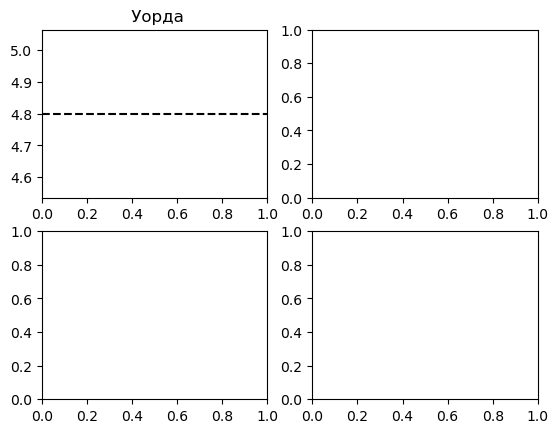

In [13]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

linkage_types = ['ward', 'complete', 'average', 'single']
cutoff_thresholds = [4.8, 2, 1, 0.5]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = [' Уорда', 'Полной связи', "Средней связи", "Одиночной связи"]
linkage_labels = dict(zip(linkage_types, labels))

mpl.rcParams.update(mpl.rcParamsDefault)
hclust = dict()
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type)
    clustering = model.fit(X)
    axs[axs_ind].set_title(linkage_labels[linkage_type])
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        clustering,
        truncate_mode="level",
        p=6,
        ax=axs[axs_ind],
        labels=None,
        color_threshold = linkage_colors[linkage_type]
        # orientation='right'
        )

    hclust[linkage_type] = {
        "clustering": clustering,
        "linkage_matrix": linkage_matrix
    }
# fig.tight_layout()
fig.set_size_inches(25, 10.5)
fig.set_dpi(1000)
plt.show()

In [14]:
a = np.arange(149, 2)

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z=linkage(iris_data.data, 'ward')

In [16]:
from sklearn.cluster import AgglomerativeClustering as AC
clustering = AC(n_clusters=3, compute_distances=True).fit(iris_data.data)
# print(clustering.distances_.shape)
clustering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int64)

In [17]:
model = AgglomerativeClustering(linkage='ward')
model.fit(X1.to_numpy())
print(*model.agglomerative_schedule, sep='\n')

NameError: name 'X1' is not defined

In [ ]:
X2 = pd.read_excel('iris_data/clustering.xlsx', sheet_name='dist_matrix', header=None)
X2

In [ ]:
model = AgglomerativeClustering(metric='precomputed')
model.fit(X2.to_numpy())
print(*model.agglomerative_schedule, sep='\n')